# Сокращение производственных расходов металлургического комбината «Стальная птица».

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. 
Для этого комбинату нужно контролировать температуру сплава на выходе ковша. 

**Цель текущего проекта** — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса и принятия решений о конкретных действиях для экономии затрат на электроэнергию.

Для разработки модели заказчиком предоставлено: 
- Описание производственного процесса
- датасеты из нескольких источников с конкретными показателями, полученными с датчиков:
    - data_arc_new.csv — данные об электродах;
    - data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
    - data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
    - data_gas_new.csv — данные о продувке сплава газом;
    - data_temp_new.csv — результаты измерения температуры;
    - data_wire_new.csv — данные о проволочных материалах (объём);
    - data_wire_time_new.csv — данные о проволочных материалах (время).
    
Данная работа состоит из следующих этапов:
1. Загрузка данных.
2. Исследовательский анализ с построением графиков и обработка данных.
3. Объединение всего массива данных в один датафрейм для работы с моделированием
4. Разработка моделей для предсказания температуры сплава
5. Выбор лучшей модели.
6. Выводы и рекомендации Заказчику.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [4]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [5]:
from sklearn.dummy import DummyRegressor

In [6]:
!pip install phik -q

In [7]:
from phik import phik_matrix

In [8]:
RANDOM_STATE = 3062025
TEST_SIZE = 0.25

## Загрузка данных.

In [9]:
def information(df):
    display(df.head())
    print('---------------------------------------------------------------------------------------------------------')
    display(df.info()) 
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Количество дубликатов: {df.duplicated().sum()}')
    print('---------------------------------------------------------------------------------------------------------')
    print('Количество пропусков:')
    print(df.isna().sum())
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Описание: ')
    display(df.describe())
    print('---------------------------------------------------------------------------------------------------------')
    print(f'Размер: {df.shape}')

**Загрузка data_arc_new**

In [10]:
try:
    data_arc_new = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Выпускной проект\data_arc_new.csv", parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
except:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])

In [11]:
information(data_arc_new)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:
key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


---------------------------------------------------------------------------------------------------------
Размер: (14876, 5)


Из описания видно, что операций нагрева в датасете 14876 штук. Значения `key` повторяются. Это обосновано тем, что в рамках одной партии проводится несколько операций нагрева. 

- Количество партий - 3241.
- имеется отрицательное значение реактивной мощности.


Приведем названия колонок к змеиному регистру.

In [12]:
data_arc_new.columns = ['key', 'start_heating', 'end_heating','active_power', 'reactive_power']

Добавим колонку со временем нагрева

In [13]:
data_arc_new['duration_heating'] = data_arc_new['end_heating'] - data_arc_new['start_heating']
data_arc_new['duration_heating'] = data_arc_new['duration_heating'].dt.seconds

**Загрузка data_bulk_new**

In [14]:
try:
    data_bulk_new = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Выпускной проект\data_bulk_new.csv")
except:
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')

In [15]:
information (data_bulk_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


---------------------------------------------------------------------------------------------------------
Размер: (3129, 16)


Количество операций с добавлением сыпучих материалов - 3129. Имеется много пропусков в колонках Bulk1-Bulk15. Всего 1 операция с добавлением Bulk 8.

Приведем названия колонок к единому стандарту.

In [16]:
data_bulk_new.columns = data_bulk_new.columns.str.lower()

In [17]:
data_bulk_new.columns = data_bulk_new.columns.str.replace(' ', '_')

**Загрузка data_bulk_time_new**

In [18]:
list_1 = []
for i in range(15):
    list_1.append('Bulk ' + f'{i+1}')

In [19]:
try:
    data_bulk_time_new = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Выпускной проект\data_bulk_time_new.csv")
except:
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv', parse_dates = list_1)

In [20]:
information(data_bulk_time_new)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non

None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


---------------------------------------------------------------------------------------------------------
Размер: (3129, 16)


Логично, что количество операций с добавлением сыпучих материалов осталось 3129. Описание аналогично `data_bulk_new`

Приведем к стандарту названия колонок

In [21]:
data_bulk_time_new.columns = data_bulk_new.columns.str.lower()

In [22]:
data_bulk_time_new.columns = data_bulk_new.columns.str.replace(' ', '_')

**Загрузка data_gas_new**

In [23]:
try:
    data_gas_new = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Выпускной проект\data_gas_new.csv")
except:
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')

In [24]:
information(data_gas_new)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:
key      0
Газ 1    0
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


---------------------------------------------------------------------------------------------------------
Размер: (3239, 2)


В датасете с добавлением газа 3239 строк, отличается от количества "ковшей" - 3241

In [25]:
data_gas_new.columns = ['key', 'gas']

**Загрузка data_temp_new**

In [26]:
try:
    data_temp_new = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Выпускной проект\data_temp_new.csv")
except:
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv', parse_dates = ['Время замера'])

In [27]:
information(data_temp_new)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:
key                0
Время замера       0
Температура     3427
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


---------------------------------------------------------------------------------------------------------
Размер: (18092, 3)


В значениях с температурой имеются пропуски. Также смотря на describe видно что имеются значения ниже 1400 (температура плавления)

In [28]:
data_temp_new.columns = ['key', 'measurement_time', 'temp']

**Загрузка data_wire_new**

In [29]:
try:
    data_wire_new = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Выпускной проект\data_wire_new.csv")
except:
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')

In [30]:
information(data_wire_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


---------------------------------------------------------------------------------------------------------
Размер: (3081, 10)


Количество партий "ковшей" - с добавлением проволоки 3081.

In [31]:
data_wire_new.columns = data_wire_new.columns.str.lower()

In [32]:
data_wire_new.columns = data_wire_new.columns.str.replace(' ', '_')

**Загрузка data_wire_time_new**

In [33]:
list_2 = []
for i in range(9):
    list_2.append('Wire ' + f'{i+1}')

In [34]:
try:
    data_wire_time_new = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Выпускной проект\data_wire_time_new.csv")
except:
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv', parse_dates = list_2)

In [35]:
information(data_wire_time_new)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


---------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

---------------------------------------------------------------------------------------------------------
Количество дубликатов: 0
---------------------------------------------------------------------------------------------------------
Количество пропусков:
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
---------------------------------------------------------------------------------------------------------
Описание: 


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


---------------------------------------------------------------------------------------------------------
Размер: (3081, 10)


Описание аналогично вышеуказанному датафрейму.

In [36]:
data_wire_time_new.columns = data_wire_time_new.columns.str.lower()
data_wire_time_new.columns = data_wire_time_new.columns.str.replace(' ', '_')

**Вывод по загрузке данных:**
1. Проведена загрузка данных и первичное ознакомление.
2. Названия колонок приведены к змеиному регистру.
3. Типы данных с датой приведены к `datetime64`.
4. На данном этапе нет однозначного решения что делать с пропусками в `Bulk` и `Wire`

## Исследовательский анализ.

### Анализ data_arc_new.

In [37]:
def graphics (df):
    for i in df.columns:

        plt.rc('font', size=14)
        plt.figure(figsize=(20,5))
        plt.subplot(1,2,1)
        sns.histplot(df, x=i, bins=50)
        plt.xlabel(i)
        plt.ylabel('Количество')
        plt.title('Гистограмма '+i,fontsize = 'x-large', pad=10)
        plt.subplot(1,2,2)
        sns.boxplot(data=df, x=i)
        plt.xlabel('Значения')
        plt.ylabel(i)
        plt.title('Ящик с усами '+i,fontsize = 'x-large', pad=10)

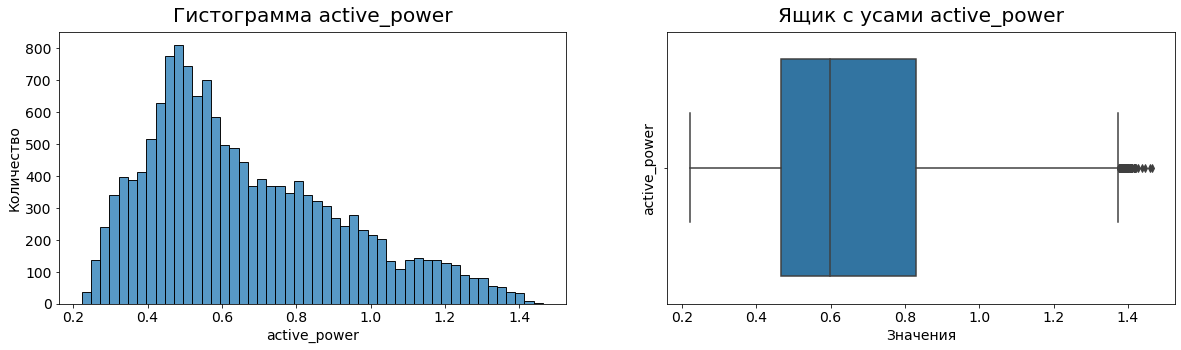

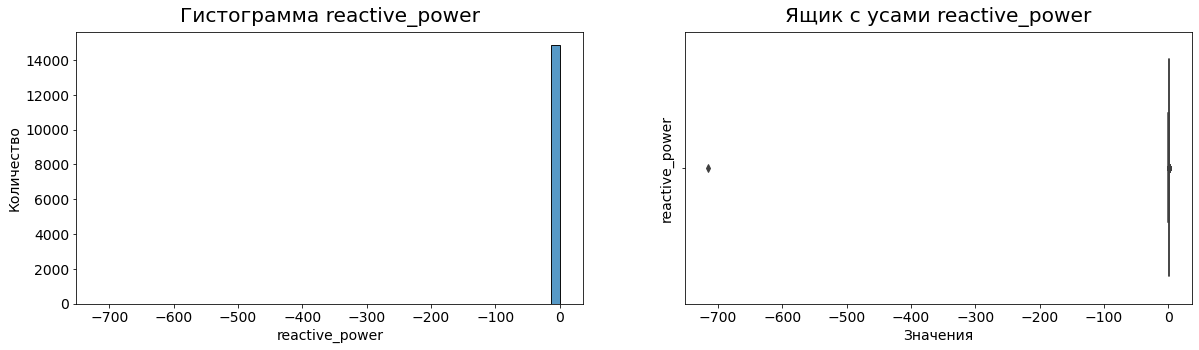

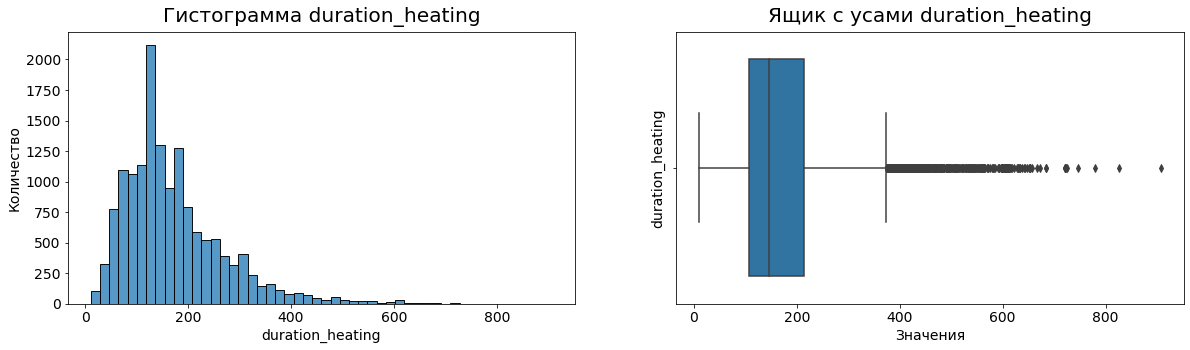

In [38]:
graphics(data_arc_new[['active_power','reactive_power', 'duration_heating']])

Видим в реактивной мощности отрицательное значение. Обработаем его.

In [39]:
data_arc_new.shape

(14876, 6)

In [40]:
# data_arc_new = data_arc_new.query('reactive_power >= 0')

In [41]:
key_for_drop = data_arc_new.query('reactive_power <0')['key'].to_list()

In [42]:
key_for_drop

[2116]

In [43]:
data_arc_new = data_arc_new[~data_arc_new['key'].isin(key_for_drop)]
data_arc_new.shape

(14872, 6)

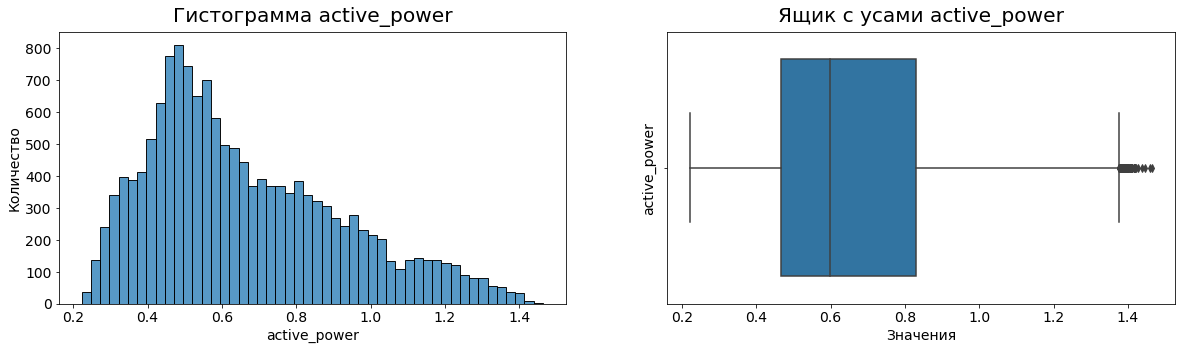

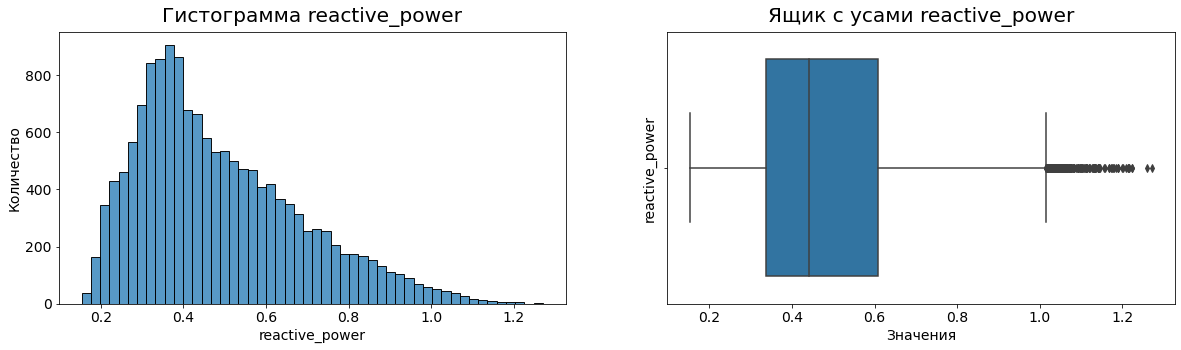

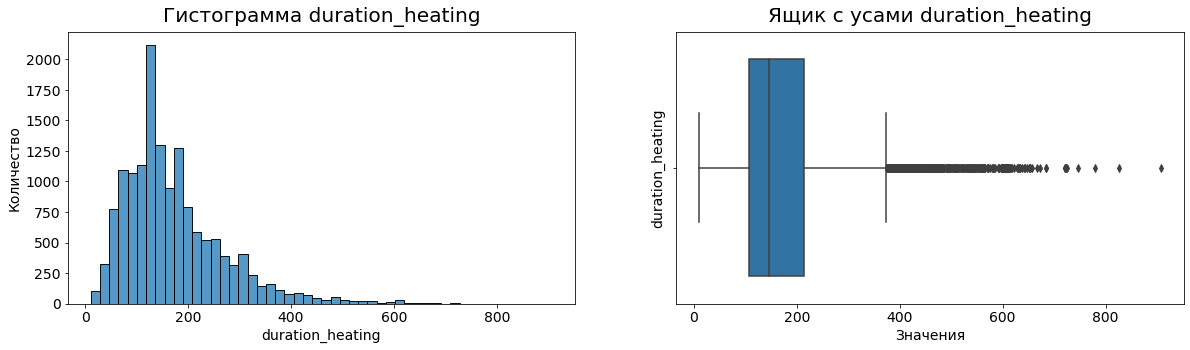

In [44]:
graphics(data_arc_new[['active_power','reactive_power', 'duration_heating']])

Во всех распределениях видим сосредоточение около определенных значений. Имеются выбросы. Ввиду специфики производства удалять значения выбросов не будем.

Добавим значение полной мощности и затрат электроэнергии.

In [45]:
data_arc_new['full_power'] = (data_arc_new['active_power']**2 + data_arc_new['reactive_power']**2)**0.5

In [46]:
data_arc_new['energy_costs'] = data_arc_new['full_power'] * data_arc_new['duration_heating']

In [47]:
def graphics_2(df, columns):
    plt.rc('font', size=14)
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    sns.histplot(df, x=columns, bins=50)
    plt.xlabel(columns)
    plt.ylabel('Количество')
    plt.title('Гистограмма '+columns,fontsize = 'x-large', pad=10)
    plt.subplot(1,2,2)
    sns.boxplot(data=df, x=columns)
    plt.xlabel('Значения')
    plt.ylabel(columns)
    plt.title('Ящик с усами '+columns,fontsize = 'x-large', pad=10)
    print(df[columns].describe())

count    14872.000000
mean         0.823385
std          0.323494
min          0.275718
25%          0.578813
50%          0.746591
75%          1.030390
max          1.898158
Name: full_power, dtype: float64


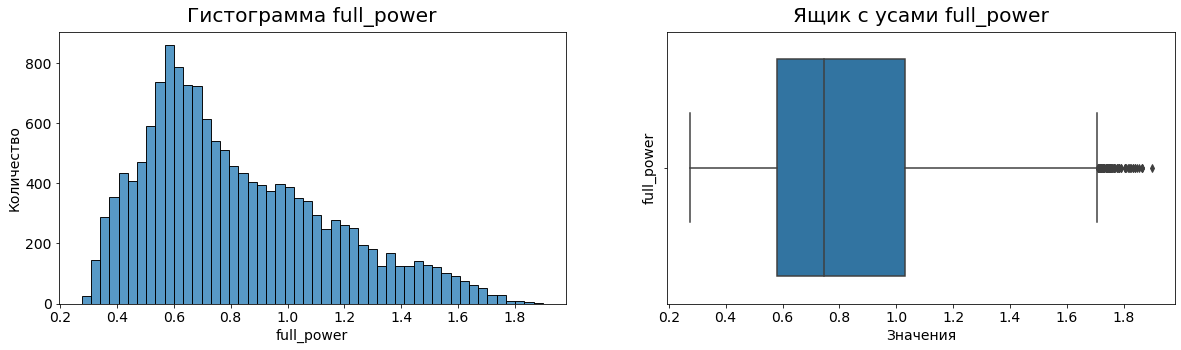

In [48]:
graphics_2(data_arc_new, 'full_power')

count    14872.000000
mean       141.657368
std        103.207107
min          6.409531
25%         71.158372
50%        114.486341
75%        181.366353
max       1084.729420
Name: energy_costs, dtype: float64


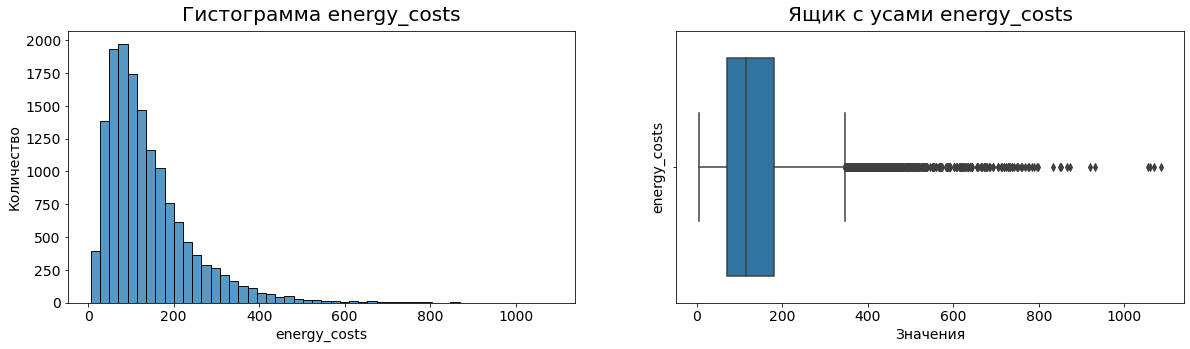

In [49]:
graphics_2(data_arc_new, 'energy_costs')

Распределение сосредоточенное вокруг медианного значения. Выбросы обрабатывать не будем.

Удалим колонки начала и конца нагрева, так как у нас есть дельта по времени.

Сгруппируем значения по "ковшам" и суммируем значения.

In [50]:
data_arc_new = data_arc_new.drop(['start_heating', 'end_heating'], axis=1).groupby('key').agg('sum')

Удалим колонки активной и реактивной мощности, так как у нас есть полная мощность.

In [51]:
data_arc_new

,active_power,reactive_power,duration_heating,full_power,energy_costs
key,,,,,
1,3.036730,2.142821,1098,3.718736,770.282114
2,2.139408,1.453357,811,2.588349,481.760005
3,4.063641,2.937457,655,5.019223,722.837668
4,2.706489,2.056992,741,3.400038,683.455597
5,2.252950,1.687991,869,2.816980,512.169934
...,...,...,...,...,...
3237,2.541872,2.025417,909,3.250657,630.503534
3238,1.374821,1.038103,546,1.723937,286.052252
3239,4.848005,3.541541,1216,6.014480,941.538764


In [52]:
data_arc_new.drop(['active_power', 'reactive_power'], axis=1, inplace=True)

### Анализ data_gas_new.

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64


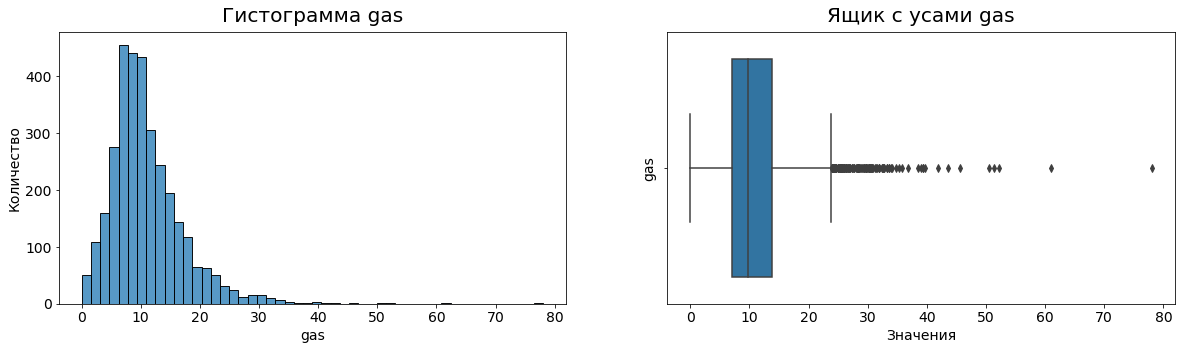

In [53]:
graphics_2(data_gas_new, 'gas')

Распределение сосредоточенное вокруг 10. Супервыбросов не обнаружено.

### Анализ data_temp_new.

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


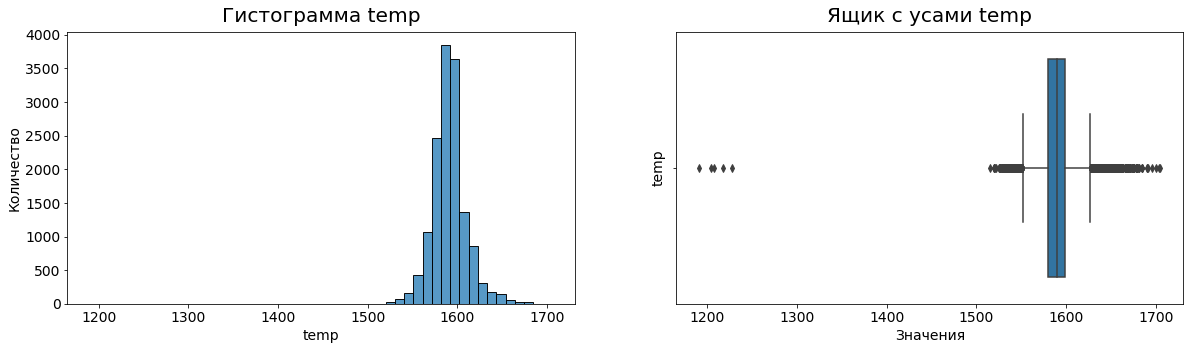

In [54]:
graphics_2(data_temp_new, 'temp')

Обработаем значения температуры ниже 1400 градусов и удалим их как выбросы.

In [55]:
data_temp_new.shape

(18092, 3)

In [56]:
# data_temp_new = data_temp_new.query('temp >=1400')
# data_temp_new.shape

In [57]:
list_for_drop = data_temp_new.query('temp < 1400')['key'].to_list()

In [58]:
data_temp_new = data_temp_new[~data_temp_new['key'].isin(list_for_drop)]
data_temp_new.shape

(18065, 3)

In [59]:
data_temp_new.dropna(inplace=True)
data_temp_new.shape

(14643, 3)

count    14643.000000
mean      1590.865055
std         19.122102
min       1519.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temp, dtype: float64


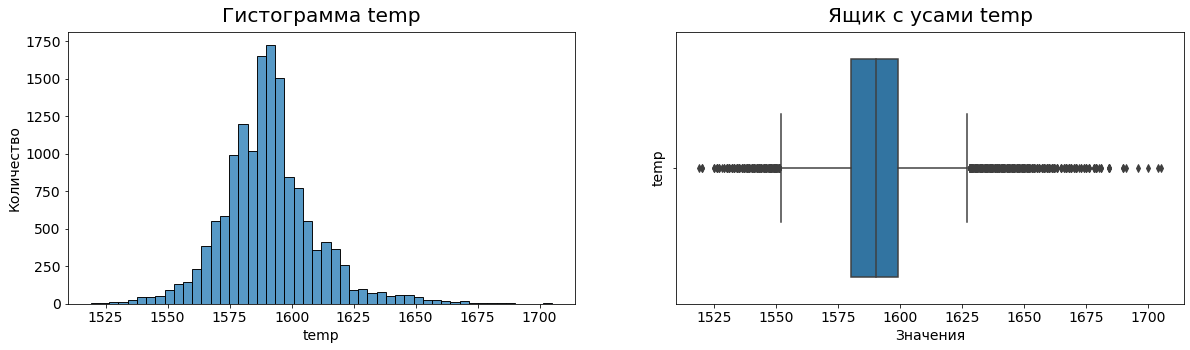

In [60]:
graphics_2(data_temp_new, 'temp')

Остальные выбросы оставим без изменений.

Отсортируем, сгруппируем по ковшам и возьмем первые и последние замеры, добавим дельту.

In [61]:
data_temp_new_1 = data_temp_new.sort_values(by='measurement_time').groupby('key').agg(['first', 'last'])
data_temp_new_1.columns = ['first_time', 'last_time', 'first_temp', 'last_temp']

In [62]:
data_temp_new_1

,first_time,last_time,first_temp,last_temp
key,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0
...,...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:31:15,1569.0,1569.0
3238,2019-09-06 12:16:15,2019-09-06 12:16:15,1584.0,1584.0
3239,2019-09-06 14:16:50,2019-09-06 14:16:50,1598.0,1598.0


Добавим дельту времени замеров

In [63]:
data_temp_new_1['diff_time'] = data_temp_new_1['last_time'] - data_temp_new_1['first_time']

In [64]:
data_temp_new_1['diff_time'] = data_temp_new_1['diff_time'].dt.seconds

In [65]:
data_temp_new_1 = data_temp_new_1.drop(['first_time', 'last_time'], axis=1)

In [66]:
data_temp_new_1.reset_index(inplace=True)

Также удалим строки с ковшами где отсутствует разница во времени замеров. Это означает что в данной партии был только один замер, производственных операции не было и предсказывать температуру на выходе не нужно, это только запутает модель и снизит ее метрику.

In [67]:
data_temp_new_1 = data_temp_new_1.query('diff_time != 0')

In [68]:
data_temp_new_1

,key,first_temp,last_temp,diff_time
0,1,1571.0,1613.0,1714
1,2,1581.0,1602.0,1265
2,3,1596.0,1599.0,1753
3,4,1601.0,1625.0,1220
4,5,1576.0,1602.0,1536
...,...,...,...,...
2468,2495,1570.0,1591.0,1380
2469,2496,1554.0,1591.0,1705
2470,2497,1571.0,1589.0,962
2471,2498,1591.0,1594.0,1520


### Анализ data_bulk_new и data_wire_new.

Посмотрим на процентное содержание пропусков.

In [69]:
df_bulk_isna = pd.DataFrame(data_bulk_new.isna().mean()*100).reset_index().rename(columns={0: 'percent', 'index':'bulk'})
df_bulk_isna.drop(0, inplace=True)

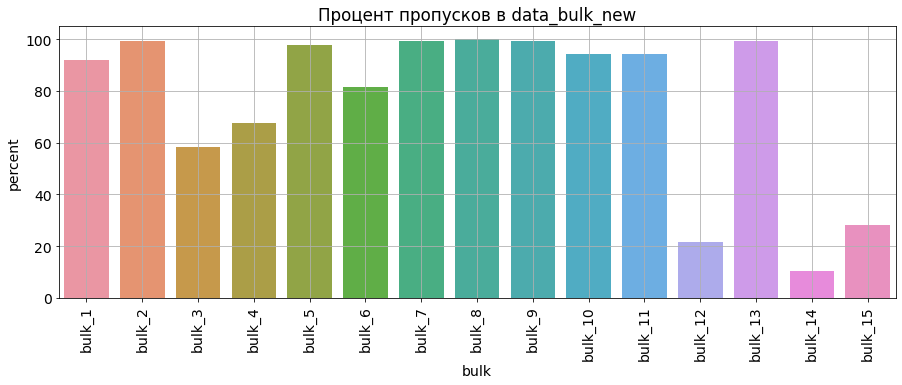

In [70]:
plt.figure(figsize=(15,5))
sns.barplot(data=df_bulk_isna, x='bulk', y='percent')
plt.xticks(rotation=90)
plt.title('Процент пропусков в data_bulk_new')
plt.grid()

Для облегчения работы модели оставим только те Bulk и Wire, в которых процент пропуска меньше 80% и заменим пропуски нулями.

In [71]:
data_bulk_new = data_bulk_new[['key','bulk_3', 'bulk_4', 'bulk_12', 'bulk_14', 'bulk_15']]

In [72]:
data_bulk_new = data_bulk_new.fillna(0)

In [73]:
df_wire_isna = pd.DataFrame(data_wire_new.isna().mean()*100).reset_index().rename(columns={0: 'percent', 'index':'wire'})
df_wire_isna.drop(0, inplace=True)

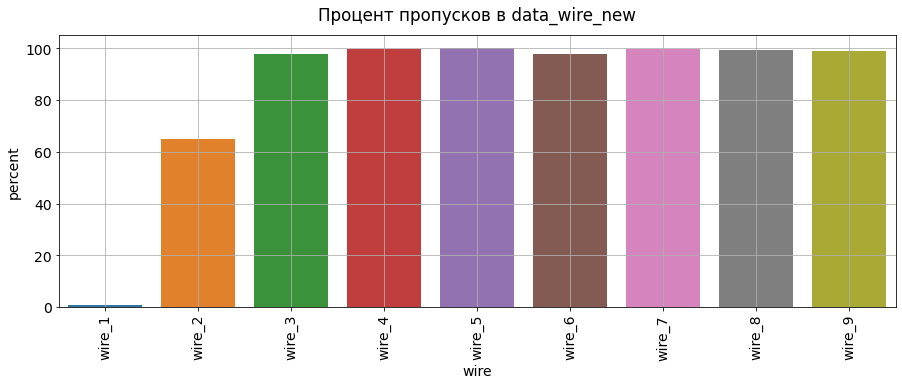

In [74]:
plt.figure(figsize=(15,5))
sns.barplot(data=df_wire_isna, x='wire', y='percent')
plt.xticks(rotation=90)
plt.title('Процент пропусков в data_wire_new', pad=15)
plt.grid()

In [75]:
data_wire_new = data_wire_new[['key','wire_1', 'wire_2']]

In [76]:
data_wire_new = data_wire_new.fillna(0)

### Анализ data_bulk_time_new и data_wire_time_new.

Для построения модели в рамках данного проекта не будем использовать показатель времени, соответственно для облегчения модели не нужно использовать датасеты с временем добавления сыпучей присадки или проволоки.

**Вввод по исследовательскому анализу:**
1. Составлены графики по всем данным.
2. Обработаны супервыбросы и лишние для модели данные:
    - Удалены записи со значением температуры ниже 1400 (температура плавления);
    - Удалены отрицательные значения реактивной мощности.
    - Удалены строки с ковшами, где имеется только один замер.
3. Добавлены колонки полной мощности и затрат электроэнергии, дельта по времени замеров. Проведена группировка и агрегация данных.
4. Удалены колонки Bulk и Wire с проценом пропусков более 80.

## Объединение данных.

Выполним последовательно `merge` для 5 датасетов по столбцу `key`

In [77]:
df_all = data_arc_new.merge(data_temp_new_1, on='key', how='inner')
df_all = df_all.merge(data_gas_new, on='key', how='inner')
df_all = df_all.merge(data_bulk_new, on='key', how='inner')
df_all = df_all.merge(data_wire_new, on='key', how='inner')

In [78]:
df_all

,key,duration_heating,full_power,energy_costs,first_temp,last_temp,diff_time,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,1,1098,3.718736,770.282114,1571.0,1613.0,1714,29.749986,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000
1,2,811,2.588349,481.760005,1581.0,1602.0,1265,12.555561,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000
2,3,655,5.019223,722.837668,1596.0,1599.0,1753,28.554793,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000
3,4,741,3.400038,683.455597,1601.0,1625.0,1220,18.841219,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000
4,5,869,2.816980,512.169934,1576.0,1602.0,1536,5.413692,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,2495,723,3.868721,694.177326,1570.0,1591.0,1380,7.125735,21.0,0.0,256.0,129.0,223.0,89.150879,0.00000
2320,2496,940,5.070316,815.818538,1554.0,1591.0,1705,9.412616,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000
2321,2497,569,4.360918,823.020520,1571.0,1589.0,962,6.271699,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800
2322,2498,750,3.909917,581.810739,1591.0,1594.0,1520,14.953657,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000


## Исследование объединенного датасета.

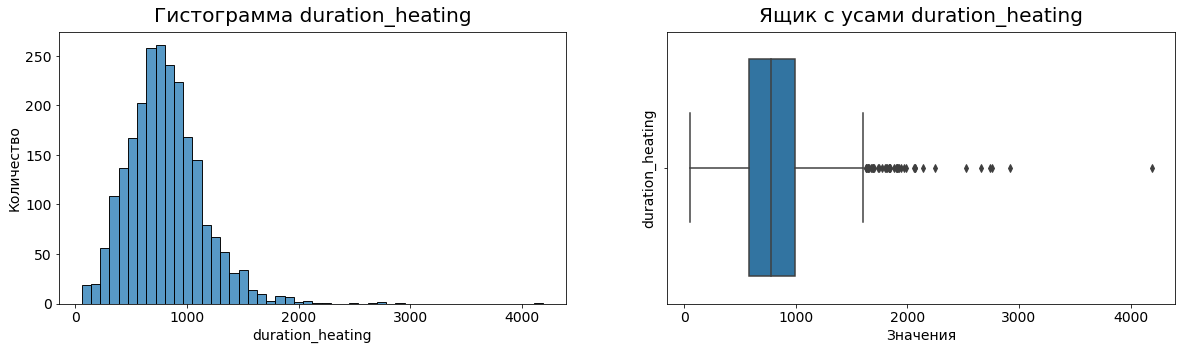

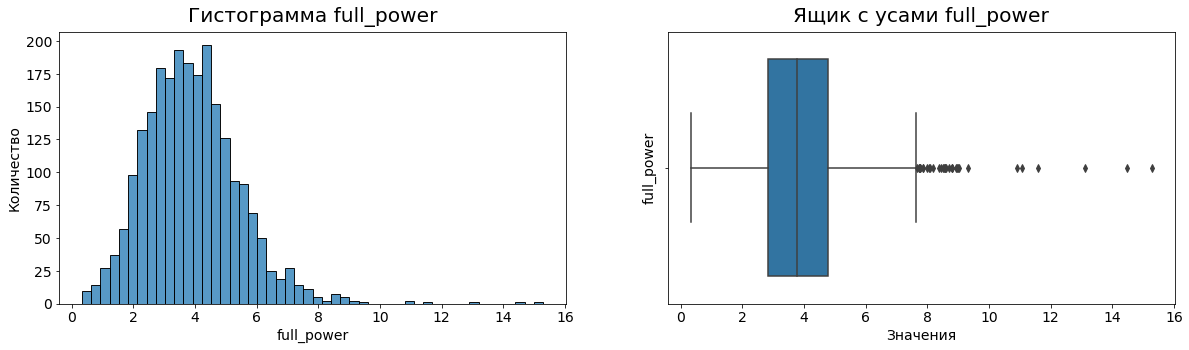

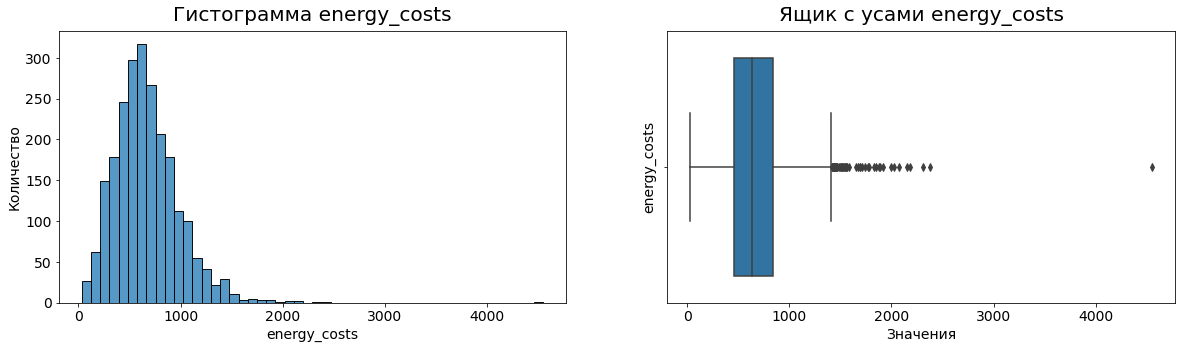

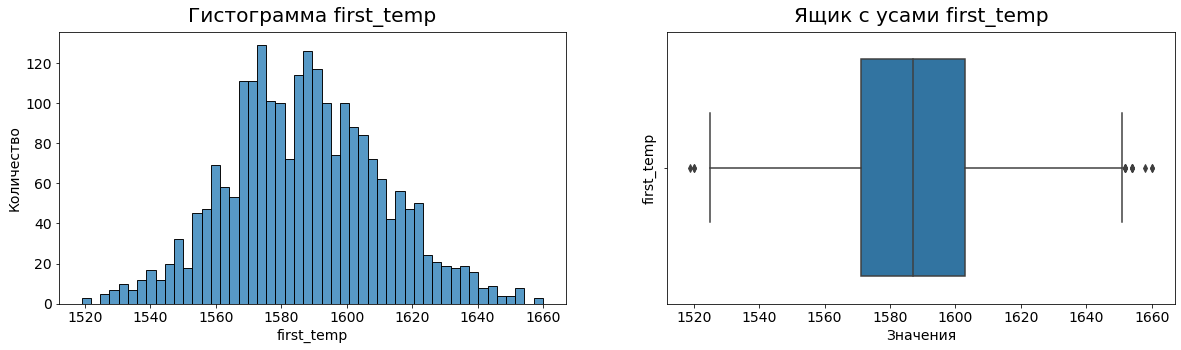

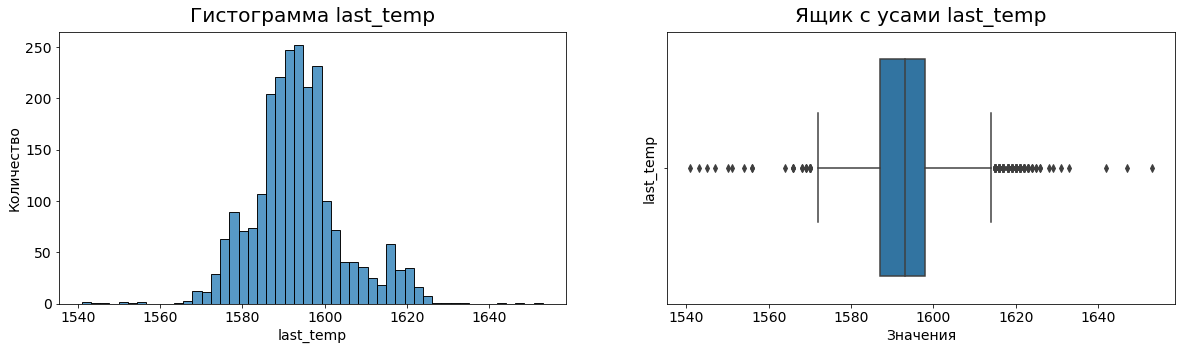

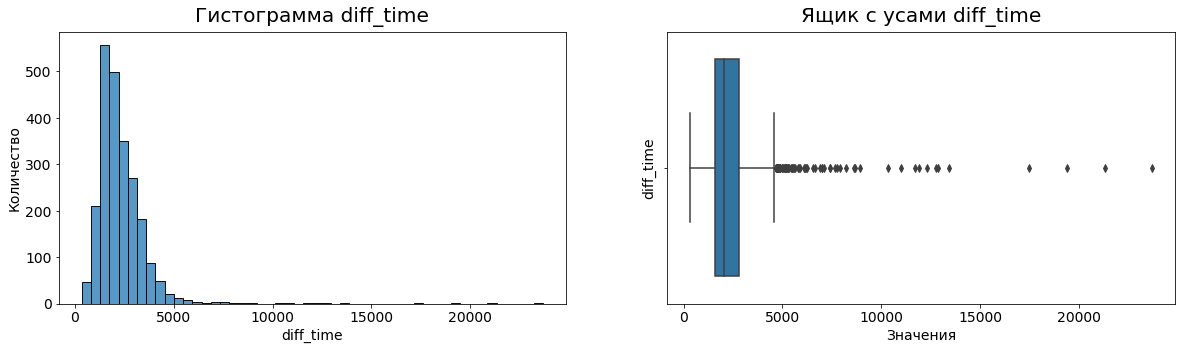

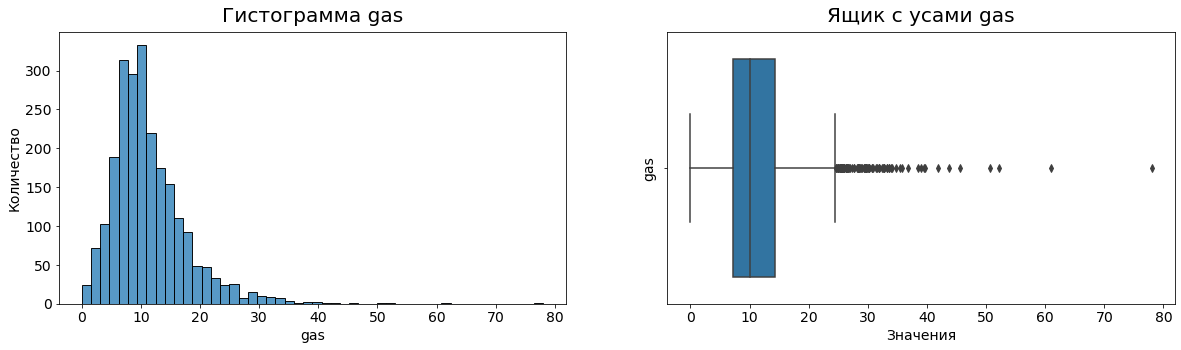

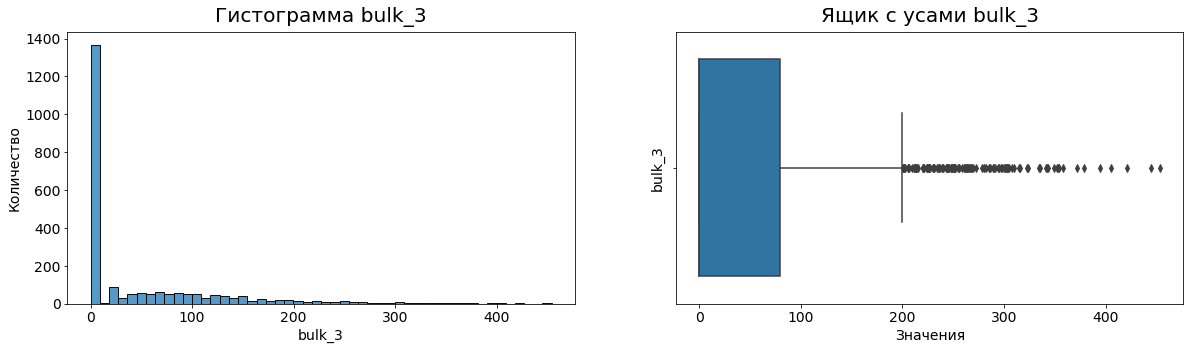

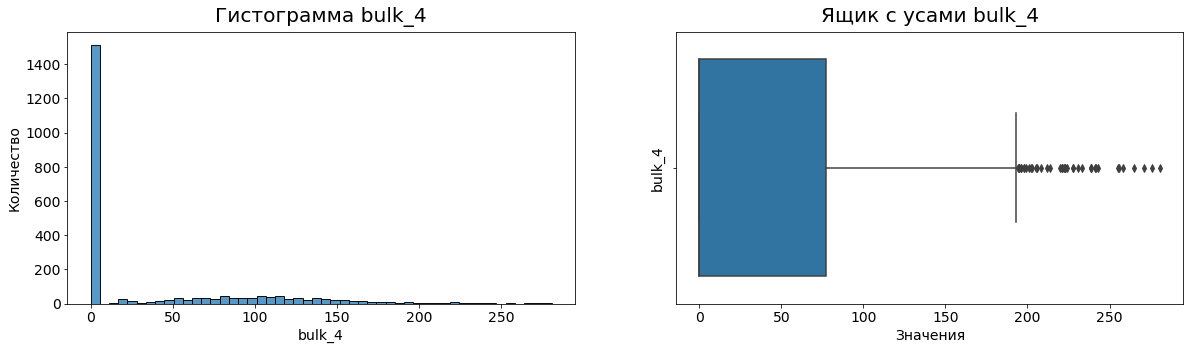

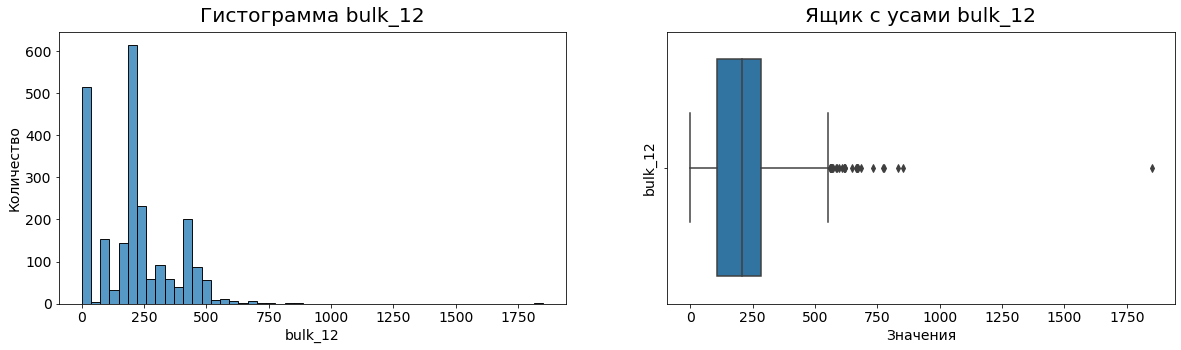

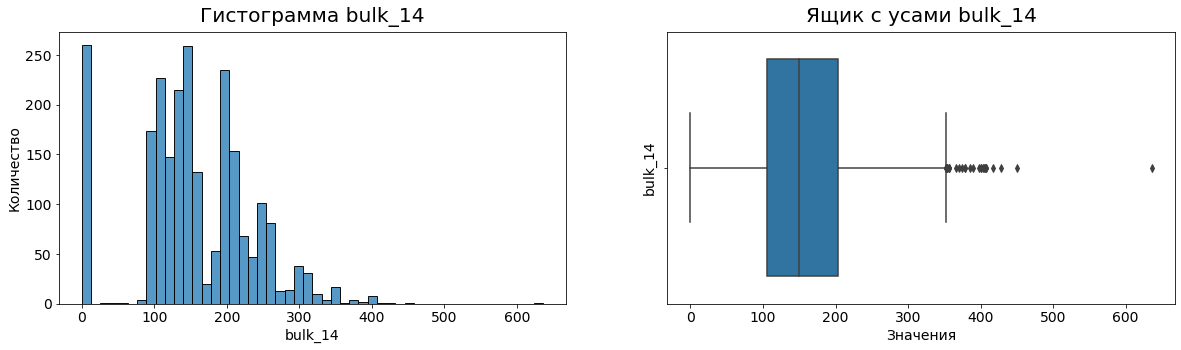

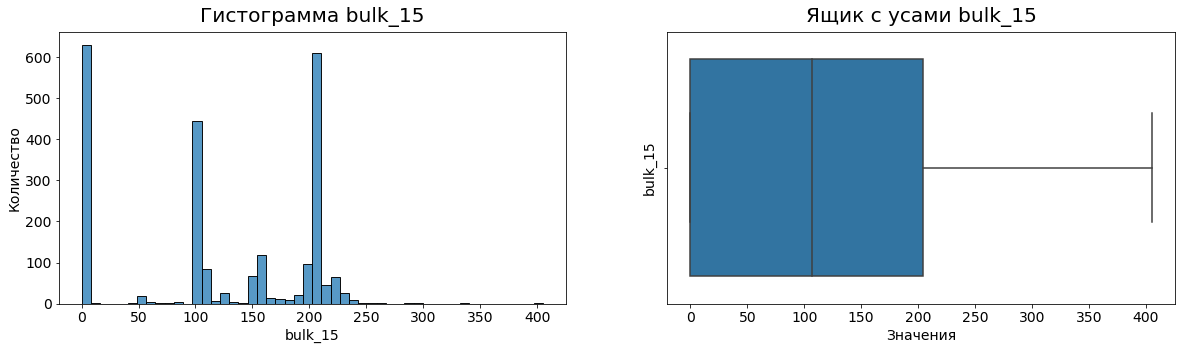

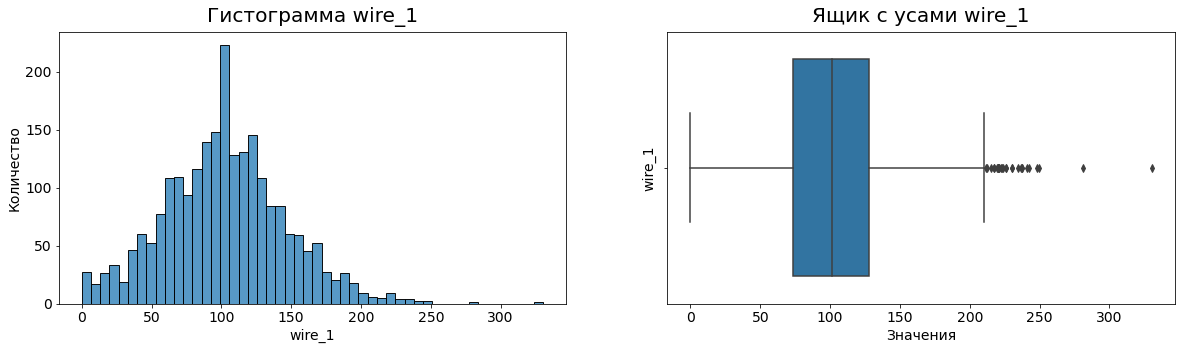

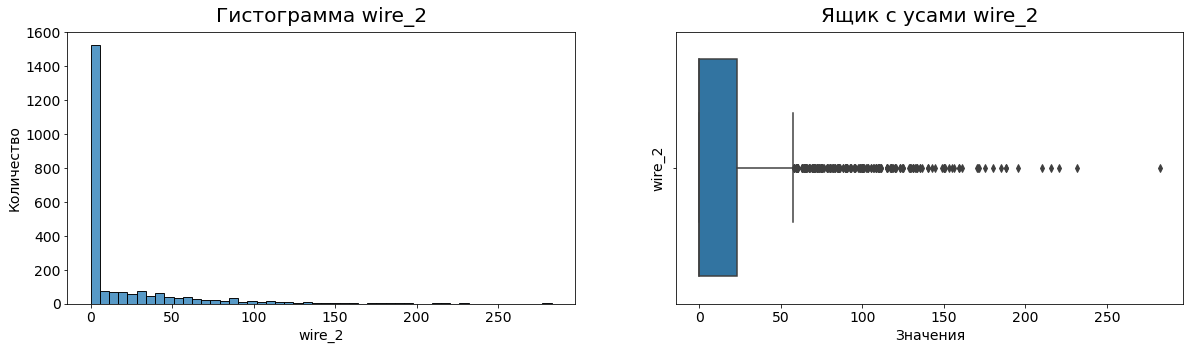

In [79]:
graphics (df_all.drop('key', axis=1))

Видим выбивающиеся количества значений по сыпучим материалам и проволоке, скорее обусловлены спецификой производства, удалять данные не будем.

## Тепловая карта.

In [80]:
phik_matrix = df_all.drop('key', axis = 1).phik_matrix(interval_cols = df_all.columns)

Text(0.5, 1.0, 'Тепловая карта признаков df_all')

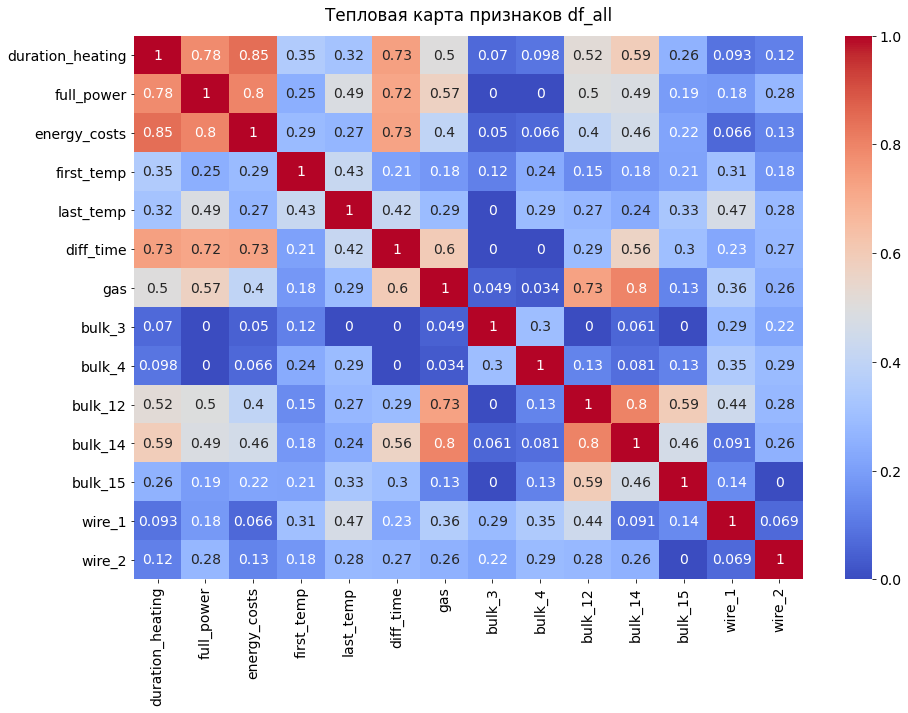

In [81]:
plt.figure(figsize=(15,10))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True)
plt.title('Тепловая карта признаков df_all', pad=15)

Видим, что коррелируют между собой `duration_heating`- `full_power` - `energy_costs`. Удалим `duration_heating`- `full_power`. 

In [82]:
df_all.drop(['duration_heating', 'full_power'], axis=1, inplace=True)

## Подготовка данных для моделирования.

Объект моделирования - конечная температура в ковше.

In [83]:
X = df_all.drop(['last_temp','key'], axis =1)
y = df_all['last_temp']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = RANDOM_STATE, test_size = TEST_SIZE)

In [84]:
X_train.shape

(1743, 11)

In [85]:
X_test.shape

(581, 11)

In [86]:
df_all.drop('key', axis =1, inplace=True)
df_all

,energy_costs,first_temp,last_temp,diff_time,gas,bulk_3,bulk_4,bulk_12,bulk_14,bulk_15,wire_1,wire_2
0,770.282114,1571.0,1613.0,1714,29.749986,0.0,43.0,206.0,150.0,154.0,60.059998,0.00000
1,481.760005,1581.0,1602.0,1265,12.555561,0.0,73.0,206.0,149.0,154.0,96.052315,0.00000
2,722.837668,1596.0,1599.0,1753,28.554793,0.0,34.0,205.0,152.0,153.0,91.160157,0.00000
3,683.455597,1601.0,1625.0,1220,18.841219,0.0,81.0,207.0,153.0,154.0,89.063515,0.00000
4,512.169934,1576.0,1602.0,1536,5.413692,0.0,78.0,203.0,151.0,152.0,89.238236,9.11456
...,...,...,...,...,...,...,...,...,...,...,...,...
2319,694.177326,1570.0,1591.0,1380,7.125735,21.0,0.0,256.0,129.0,223.0,89.150879,0.00000
2320,815.818538,1554.0,1591.0,1705,9.412616,0.0,63.0,256.0,129.0,226.0,114.179527,0.00000
2321,823.020520,1571.0,1589.0,962,6.271699,0.0,85.0,230.0,124.0,226.0,94.086723,9.04800
2322,581.810739,1591.0,1594.0,1520,14.953657,90.0,0.0,206.0,129.0,207.0,118.110717,0.00000


## Построение модели Линейной регрессии.

Условие - MAE на тестовой выборке должно быть меньше 6.8

In [87]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [88]:
cv_linear = cross_val_score(model, X_train, y_train, scoring = 'neg_mean_absolute_error').mean() * -1
cv_linear

6.736722515829318

При построении моделей с количественными значениями признаков отлично справляется классическая линейная регрессия.

**Вывод по линейной регрессии:**

Метрика линейной регрессии на тренировочной выборке составила:
- Среднее значение МАЕ при кросс-валидации - 6.714


## Построение ансамбля CatBoostRegressor.

In [92]:
%%time
model_catboost = CatBoostRegressor(verbose=False, loss_function = 'MAE', depth = 5, learning_rate = 0.1, n_estimators = 1000, random_state = RANDOM_STATE)
model_catboost.fit(X_train, y_train)
cv_catboost = abs(cross_val_score(model_catboost, X_train, y_train, scoring='neg_mean_absolute_error')).mean()

CPU times: user 9.11 s, sys: 473 ms, total: 9.58 s
Wall time: 15.1 s


In [93]:
cv_catboost

6.6354049623883835

Выше закоментил - подбор гиперпараметров занимает время. Для ускорения проверки прописал CatBoostRegressor c уже подобранными лучшими гиперпараметрами. Средняя МАЕ при кросс-валидации составила **6.635**

- 'depth': 5,
- 'learning_rate': 0.1,
- 'loss_function': 'MAE',
- 'n_estimators': 1000,
- 'random_state': 3062025

## Построение ансамбля LightGBM.

In [94]:
%%time
model = LGBMRegressor()
params = {
    'metric':['MAE'],
    'num_leaves': [10,15],
    'max_depth': [5,10], 
    'learning_rate': [0.05], 
    'random_state': [RANDOM_STATE],
}
ligbm_grid = GridSearchCV(model, params, cv=5,verbose=3, scoring='neg_mean_absolute_error')
ligbm_grid.fit(X_train, y_train)
ligbm_cv = abs(ligbm_grid.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=10, random_state=3062025; total time=   0.4s
[CV 2/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=10, random_state=3062025; total time=   0.3s
[CV 3/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=10, random_state=3062025; total time=   0.4s
[CV 4/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=10, random_state=3062025; total time=   0.4s
[CV 5/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=10, random_state=3062025; total time=   0.4s
[CV 1/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=15, random_state=3062025; total time=   0.5s
[CV 2/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=15, random_state=3062025; total time=   0.6s
[CV 3/5] END learning_rate=0.05, max_depth=5, metric=MAE, num_leaves=15, random_state=3062025; total time=   0.5s
[CV 4/5] END learning_rate=0

In [95]:
ligbm_grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'metric': 'MAE',
 'num_leaves': 10,
 'random_state': 3062025}

In [96]:
ligbm_cv

6.658467741700319

Модель LightGBM на тренировочной выборке показала результат по МАЕ - **6.658**.

Гиперпараметры у модели следующие:
- 'learning_rate': 0.05,
- 'max_depth': 10,
- 'metric': 'MAE',
- 'num_leaves': 15,
- 'random_state': 3062025

**Вывод:**

Подготовленная выборка данных разбита на тренировочную и тестовую в соотношении 3 к 1.
Размерность выборки для моделирования:
- X_train - 1743
- X_test - 581

Задан параметр RANDOM_STATE = 3062025.

Проведено обучение моделей LinearRegression, CatBoostRegressor, LGBMRegressor.

На тренировочной выборке модели показали следующие средние значения МАЕ при кросс валидации:
- LinearRegression -  **6.737**
- CatBoostRegressor - **6.635**
- LGBMRegressor - **6.658**.

## Сравнение моделей.

Составим итоговую таблицу со значениями МАЕ на тренировочной выборке по каждой модели.

In [97]:
table = pd.DataFrame({'model':['LinearRegression', 'CatboostRegressor', 'LightGBM'], 'MAE_train':[cv_linear, cv_catboost, ligbm_cv]})

In [98]:
table['MAE_train'] = table['MAE_train'].apply(lambda x: round(x,3))

In [99]:
table

,model,MAE_train
0,LinearRegression,6.737
1,CatboostRegressor,6.635
2,LightGBM,6.658


По результатам таблицы видно, что лучше всех на тренировочной выборке показал себя **CatboostRegressor**. 

Лучшей моделью признан **CatboostRegressor**. Теперь проверим его работу на тестовой выборке.

In [100]:
MAE = mean_absolute_error(y_test, model_catboost.predict(X_test))

In [101]:
round(MAE,3)

6.408

Значение МАЕ лучшей модели на тестовой выборке составило 6.408 - соответствует условию ( < 6.8)

## Анализ важности признаков.

In [102]:
model_catboost.feature_importances_

array([17.62314948, 18.29931948, 11.41211837,  7.19962504,  3.21319175,
        2.71444729,  7.34903697,  6.76312143,  7.04099242, 11.86508947,
        6.51990831])

In [103]:
df_from_plot = pd.DataFrame({'features_importances': list(model_catboost.feature_importances_), 'features': X_train.columns})

In [104]:
df_from_plot = df_from_plot.sort_values(by='features_importances', ascending=False)

Text(0, 0.5, 'Признаки')

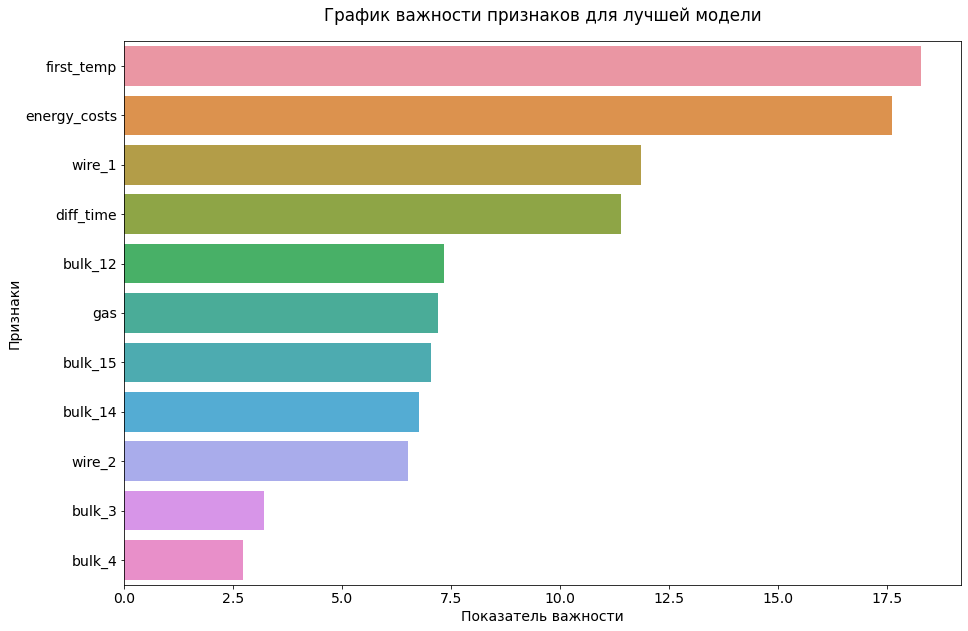

In [105]:
plt.figure(figsize=(15,10))
sns.barplot(data = df_from_plot, x='features_importances', y = 'features')
plt.title('График важности признаков для лучшей модели', pad=20)
plt.xlabel('Показатель важности')
plt.ylabel('Признаки')

Помимо очевидных факторов, таких как первоначальная температура и длительность нагрева, сильное влияние оказывает добавление проволоки wire_1 и разница во времени между последним и первым замером.

**Проверка модели на адекватность**

In [106]:
model_dummy = DummyRegressor('mean')
model_dummy.fit(X_train, y_train)
MAE_dummy = mean_absolute_error (y_test, model_dummy.predict(X_test))

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass strategy=mean as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [107]:
MAE_dummy

7.819680986053881

Метрика Dummy показала худшие результаты чем выбранная модель CatBoostRegressor. 

## Общие выводы и рекомендации Заказчику.

В данной работе путем осуществления всех этапов (краткие выводы по каждому этапу ниже) была построена модель CatBoostRegressor для предсказания конечной температуры ковша на основании списка входных параметров:
- 'energy_costs',
- 'first_temp',
- 'wire_1',
- 'diff_time',
- 'key',
- 'bulk_12',
- 'wire_2',
- 'gas',
- 'bulk_14',
- 'bulk_15',
- 'bulk_4',
- 'bulk_3'

Метрика МАЕ данной модели на тестовой выборке составила 6.457 (то есть в среднем модель ошибается на 6.46 градусов в плюс или минус). 

Параметры модели подобраны следующие:
- 'depth': 5,
- 'learning_rate': 0.1,
- 'loss_function': 'MAE',
- 'n_estimators': 1000,
- 'random_state': 3062025

Также проведен анализ важности для модели всех входных параметров.

**Рекомендация Заказчику:**
1. Применять в работе вышеуказанную модель для предсказания температуры сплава на выходе.
2. При принятии решений о корректировке технологического процесса учесть график важности признаков модели приведенный в 11 разделе. 
3. Помимо очевидных факторов, таких как первоначальная температура и длительность нагрева, сильное влияние оказывает добавление проволоки wire_1 и разница во времени между последним и первым замером (общая длительность всех операции партии "ковша")







Краткие выводы и отчет о проведенной работе по разделам:
1. **Загрузка данных.**
    - Проведена загрузка данных и первичное ознакомление.
    - Названия колонок приведены к змеиному регистру.
    - Типы данных с датой приведены к `datetime64`.
    
    
2. **Исследовательский анализ.**
    - Составлены графики по всем данным.
    - Обработаны супервыбросы и лишние для модели данные:
        - Удалены записи со значением температуры ниже 1400 (температура плавления);
        - Удалены отрицательные значения реактивной мощности.
        - Удалены строки с ковшами, где имеется только один замер.
    - Добавлены колонки полной мощности и затрат электроэнергии, дельта по времени замеров. Проведена группировка и агрегация данных.
    - Удалены колонки Bulk и Wire с проценом пропусков более 80.
    
    
3. **Объединение данных.** 
    Данные объединены в один датафрейм по ключу `key`.
    
    
4. **Разработка моделей для предсказания температуры сплава.**

    Подготовленная выборка данных разбита на тренировочную и тестовую в соотношении 3 к 1.
    Размерность выборки для моделирования:
        - X_train - 1746
        - X_test - 583

    Задан параметр RANDOM_STATE = 3062025.

    Проведено обучение моделей LinearRegression, CatBoostRegressor, LGBMRegressor.

    На тренировочной выборке модели показали следующие средние значения МАЕ при кросс валидации:
        - LinearRegression -  **6.737**
        - CatBoostRegressor - **6.635**
        - LGBMRegressor - **6.658**.
5. **Выбор лучшей модели.**. Выбрана модель CatBoostRegressor.

Дополнительный вывод:
С целью сокращения затрат предприятия путем уменьшения дельты температуры выделена категория с разницей температуры более 48.5 и проведено сравнение ковшей этой категории с общей картиной по всему датасету.

Выявлено следующее:
- в выделенной категории диапазон количества добавляемых материалов Bulk_12 и Bulk_14 выше по значениям.

**Дополнительная рекомендация:**

При построении технологического процесса  учесть факт, что добавление Bulk_12 и Bulk_14 требует большего нагрева ковша, чем другие добавки.